# Import packages

### Import python packages

In [1]:
import re,os,glob
os.environ["CUDA_VISIBLE_DEVICES"]="7"
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output
import pandas as pd
import math
import random
from datetime import datetime
from scipy.stats import linregress
from sklearn.decomposition import PCA
from tqdm import trange, tqdm
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import scipy
from scipy import interpolate
tfk = tf.keras
tfkl = tf.keras.layers
clear_output()

### Import custom packages

In [2]:
from MRA_generate import MRA_generate
from parameters import *
import symae_core as symae
from movie_redatum import movie_redatum 
p=2;q=2
path = './new_drop_p=%d,q=%d,sym_man'%(p,q)

# Generate dataset X

### Define $n_\varepsilon$ states

In [3]:
def g(n,x):
    if n==0:
        return int(x<0.5)
    elif n==1:
        return math.cos(2*math.pi*x)/2 + 0.5
    elif n==2:
        if x<0.5: 
            return 1-2*x
        else:     
            return 0
    elif n==3:
        return 2*int(x<0.5)-1
    elif n==4:
        return math.cos(2*math.pi*x)
    elif n==5:
        if x<0.5: 
            return 1-4*x
        else:     
            return -1

Text(0.5, 0.98, 'Show the shape of all $n_\\epsilon$ = 6 states')

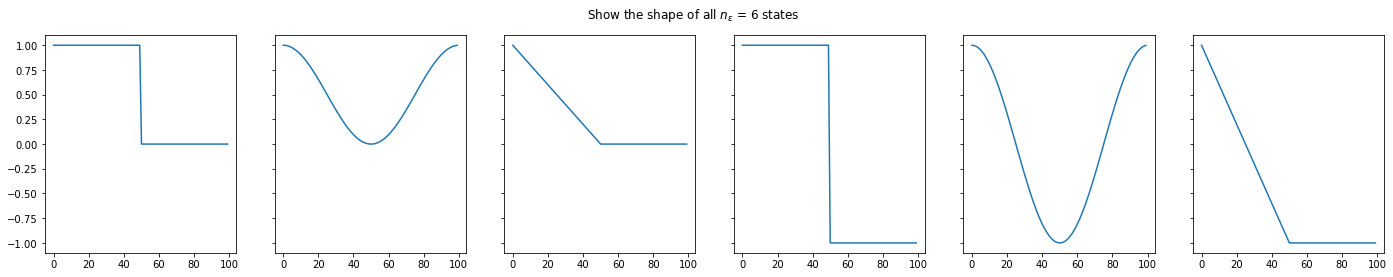

In [4]:
fig, axs = plt.subplots(1, ne, sharex=True, sharey=True, figsize=(ne*4, 4))
for i in range(ne):
    axs[i].plot(range(d), [g(i,x/d) for x in range(d)])
plt.suptitle('Show the shape of all $n_\epsilon$ = %d states'%ne)

### Generate the dataset

In [5]:
MRA_training = MRA_generate(d,nt,N,0,ne,g,replace=0,continuous=False)
MRA_training.generate_default()
X = MRA_training.X
states = MRA_training.states
shifts = MRA_training.shifts

### Print the structure of dataset X

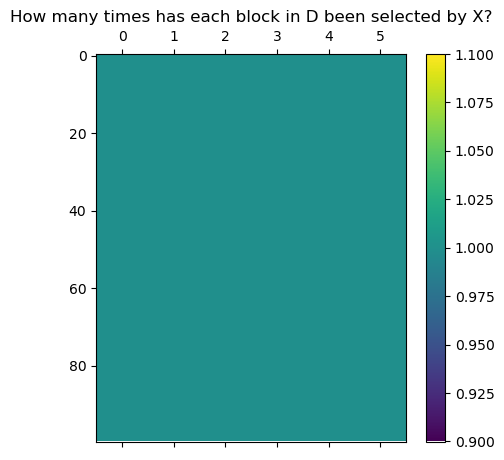

In [6]:
select_times = MRA_training.select_times
plt.figure(figsize=(5,5),dpi=100)
plt.matshow(select_times.T, aspect='auto', fignum=1)
plt.colorbar()
plt.title('How many times has each block in D been selected by X?')
plt.show()

# Train SymAE

In [7]:
class LatentCat(tf.keras.Model):
    def __init__(self):
        super(LatentCat, self).__init__(name = 'latentcat')
    def call(self, zsym, znuisance, mask=1.0, training=False):
        tf.cast(mask, tf.float32)
        
        znuisance = znuisance*mask
        znuisance = tfkl.Flatten()(znuisance)
        z = tfkl.concatenate([zsym, znuisance])
        return z

In [8]:
class SymAE(tf.keras.Model):
    def __init__(self, N, nt, d, p, q): 
        super(SymAE, self).__init__()
        # Build symmetric encoder
        sym_encoder = symae.SymmetricEncoder1D(p)
        self.sym_encoder = sym_encoder
        
        # Build nuisance encoder
        nui_encoder = symae.NuisanceEncoder1D(q)
        self.nui_encoder = nui_encoder
        
        # Build distribute in decoder
        distzsym = symae.DistributeZsym(nt, p, q)
        self.distzsym = distzsym
        
        #Build mixer in decoder
        mixer = symae.Mixer1D(d)
        self.mixer = mixer
        
        # Build latentcat
        latentcat = LatentCat()
        self.latentcat = latentcat        
        
        # Build encoder
        encoder_input = tfk.Input(shape=(nt,d,1), dtype='float32', name='encoder_input')
        znuisance = nui_encoder(encoder_input)
        zsym = sym_encoder(encoder_input)
        encoder_output = latentcat(zsym,znuisance)
        encoder = tfk.Model(encoder_input, encoder_output, name="encoder")
        self.encoder = encoder
        
        # Build decoder
        decoder_input = tfk.Input(shape=(p+q*nt), name='latentcode')
        decoder_output = mixer(distzsym(decoder_input))
        decoder = tfk.Model(decoder_input,decoder_output, name="decoder") 
        self.decoder = decoder
        
    def call(self, x, mask=1.0):
        sym_code = self.sym_encoder(x)
        nui_code = self.nui_encoder(x)
        z = self.latentcat(sym_code, nui_code, mask)
        dist = self.distzsym(z)
        out = self.mixer(dist)
        return out

### Initialize SymAE and load weights

In [9]:
#import symae_model 
model = SymAE(N,nt,d,p,q)
#model = symae_model.SymAE(N,nt,d,p,q,5,64,0.0)
clear_output()

In [10]:
try: 
    #model.load_weights(path+'/checkpoint')
    print("old")    
except:
    print("new")

old


### Train the NeuralNet

In [11]:
optimizer = tf.keras.optimizers.Adam(0.001)
mse = tf.keras.losses.MeanSquaredError()

In [12]:
std=tf.Variable(0.5)
def reconstruction_loss(model, x, training=False):
    s=0
    # mask = tf.random.uniform(shape=[3], minval=0, maxval=2, dtype=tf.int64)
    # while tf.reduce_sum(mask)<2:
    #     mask = tf.random.uniform(shape=[3], minval=0, maxval=2, dtype=tf.int64) 
    # mask = tf.cast(mask, tf.float32)
    t = tf.random.uniform(shape=[], minval=0, maxval=1) 
    #t=tf.random.normal(shape=[], mean = 1, stddev =std)
    #t2=tf.random.normal(shape=[], mean = 1, stddev =std)
    #s=tf.math.sqrt(2+t**2)
    s+= mse(x, model(x, mask=[t,t]))
    #s+= mse(x, model(x, mask=[0,1,1]))
    #s+= mse(x, model(x, mask=[1,0,1]))
    #s+= mse(x, model(x, mask=[1,1,1]))
    return s
path = './new_drop_p=%d,q=%d,'%(p,q)

@tf.function
def train_step(model, x, training=True):
    with tf.GradientTape() as tape:
        loss_rec = reconstruction_loss(model, x, training)
        #loss_cor = mutual_info_penalty(model, x, training)*0
        loss = loss_rec #+ loss_cor
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss_rec, 0

In [13]:
try:
    os.mkdir(path)
except:
    print('exists')
    
try:
    epoch = int(re.findall(r"\d+",glob.glob(path+'/*.epoch')[0])[-1])
    print(epoch)
except:
    epoch = 0
    os.mkdir(path+'/0.epoch')

In [14]:
pp='./9.1,N=%d,nt=%d,p=%d,q=%d,r=%.1f,l=%.3f'%(N,nt,p,q,0.5,0)    
model.load_weights(pp+'/checkpoint')

In [15]:
for i in range(10000):
    #std.assign(std*0.999)
    epoch += 1
    os.mkdir(path+'/%d.epoch'%epoch)
    os.rmdir(path+'/%d.epoch'%(epoch-1))    
    loss_rec, loss_cor = train_step(model, X)
    print("For epoch {:d}, reconstruction loss is {:f}."
          .format(epoch, loss_rec, loss_cor))
    clear_output(wait=True)

KeyboardInterrupt: 

### Save weights

In [ ]:
model.save_weights(path+'/checkpoint')
print("weights saved")

# Redatuming

# Plot

In [ ]:
fig = movie_redatum(g,model)
fig.savefig(path+"/redatum.pdf", format='pdf', dpi=200)

# Latent functions

In [ ]:
MRA_test = MRA_generate(d,nt,100,sigma,ne,g,replace=0,continuous=False)
MRA_test.generate_default()
clear_output()
N_code = model.nui_encoder.predict(MRA_test.X,verbose=0)
N_reshaped = N_code.reshape(-1,q)
N_states = np.repeat(MRA_test.states,nt)
N_shifts = MRA_test.shifts.reshape(-1,1)

In [ ]:
pca_N = PCA(2).fit_transform(N_reshaped)
df = pd.DataFrame(pca_N, columns = ['first principal component','second principal component'])
df_states = pd.DataFrame(N_states,columns=['state']).astype('object')
df_shifts = pd.DataFrame(N_shifts,columns=['shift'])
df = pd.concat([df,df_states,df_shifts],axis=1)
df = df.sort_values(by=['state'])
fig = px.scatter(df, x='first principal component', y='second principal component', 
                 color='state', text='shift')
fig.update_layout(width=500, height=400, title="PCA of latent nuisance codes")
fig.show()
fig.write_image(path+'/latent.pdf')

In [ ]:
MRA_test = MRA_generate(d,nt,100,sigma,ne,g,replace=0,continuous=False)
MRA_test.generate_default()
clear_output()
N_code = model.nui_encoder.predict(MRA_test.X,verbose=0)
N_reshaped = N_code.reshape(-1,q)
N_states = np.repeat(MRA_test.states,nt)
N_shifts = MRA_test.shifts.reshape(-1,1)
s_sub = [N_states==s for s in range(ne)]
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))
for i in trange(q):
    for s in range(ne):
        ax=axs[i]
        ax.scatter(N_shifts[s_sub[s]],N_reshaped[:,i][s_sub[s]],color='C%d'%s,label=s)
        ax.set_title('%d-th dim'%i)
        ax.set_xlabel('real shift')
        ax.set_ylabel('%d-th latent'%i)
        ax.legend()
        ax.grid()
fig.suptitle('latent nuisance space')
fig.show()
fig.tight_layout()
fig.savefig(path+"/redatum_all.pdf", format='pdf', dpi=200)

In [ ]:
C_code = model.sym_encoder.predict(MRA_test.X,verbose=0)
C_reshaped = C_code.reshape(-1,p)
axs=[0]
fig, axs = plt.subplots(1, p, sharex=True, sharey=True, figsize=(p*5,4))
for i in trange(p):
    for s in range(ne):
        axs[i].scatter(C_reshaped[:,i][MRA_test.states==s],np.zeros(sum(MRA_test.states==s)),color='C%d'%s)
        axs[i].set_xlabel('%d-th latent'%i)
fig.suptitle('latent coherent space')
fig.tight_layout()
fig.show()

In [ ]:
df = pd.DataFrame(model.sym_encoder(X), columns = ['1st','2nd','3rd'][0:2])
df_states = pd.DataFrame(states,columns=['state']).astype('object')
df = pd.concat([df,df_states],axis=1)
#df = df[df['state']==0]
df = df[0:1000]
fig = px.scatter(df, x='1st', y='2nd', color='state')
fig.update_layout(height=400, margin=dict(l=0, r=0, t=0, b=0))
fig.show()

In [ ]:
tf.reduce_mean(X,axis=[1,2])

In [ ]:
X.shape

In [ ]:
C = model.sym_encoder(X)

In [ ]:
states

In [ ]:
plt.scatter(C[:,0],C[:,1])

In [ ]:
df